# Pretraining via auto-encoders

- The traditional transfer learning preserver the same model architecture.

- Pre-training via auto-encoder is slightly different. It is based on training an auto-encoder on our data then we transfer only the encoder part and we have to attach some FF layers.

  - Build an auto-encoder for our data.

  - Train the auto-encoder to satisfactory performance.

  - Create a new model that has the same architecture as the encoder, and copy weights from the auto-encoder.

  - Add linear layers to the end of the new model.

  - Train the transfered model to classify the data.


**Pros and cons of autoencoder pretraining**

 - Optimize the model for your data as oppesed to traditional transfer learning which use model trained on different data.

 - Usefull with limited data (can re-use data without overfitting) because with use all of our data to pre-traine the auto-encoder and then use the same data to train the transferred model which his purpose is totally different from the purpose of the auo-encoder model and that prevent overfitting.

 - Can save computation time if using an existing model.

 - The most relevant pros of this approach is that auto-encoders do not necessarily identify the features that are relevant for classification so not every params transfers.

In [30]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data  import DataLoader,TensorDataset,Subset
import copy 
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

In [31]:
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(p=.5),
    T.Normalize(.5,.5)
])

batch_size = 32

trainset = torchvision.datasets.FashionMNIST(root='../data',train=True,download=False,transform=transform)
devset = torchvision.datasets.FashionMNIST(root='../data',train=False,download=False,transform=transform)

In [32]:
randidx = np.random.permutation(10000)
randidx

array([4698,  426, 2235, ..., 3506, 4786, 2245], shape=(10000,))

In [33]:
devset = Subset(devset,randidx[:6000])
testset = Subset(devset,randidx[6000:])

In [34]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,drop_last=True)
dev_loader = DataLoader(testset,batch_size=len(testset))
test_loader =  DataLoader(devset,batch_size=len(devset))

In [35]:
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [36]:
def AEModel():
    class aenet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            self.encconv1 = nn.Conv2d(1,16,3,padding=1,stride=2)
            self.encconv2 = nn.Conv2d(16,32,3,padding=1,stride=2)

            self.deconv1 = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
            self.deconv2 = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)

        def forward(self,x):
            x = F.leaky_relu(self.encconv1(x))
            x = F.leaky_relu(self.encconv2(x))

            x = F.leaky_relu(self.deconv1(x))
            x = F.leaky_relu(self.deconv2(x))

            return x

    net = aenet()
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=.001) 

    return net,lossfun,optimizer   

In [37]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [38]:
tmpae, tmplossfun, tmpptimizer = AEModel()
X,y = next(iter(train_loader))
yHat = tmpae(X)
print(f'yhat shape :  {yHat.shape}')


yhat shape :  torch.Size([32, 1, 28, 28])


In [39]:
ae, lossfun, optimizer = AEModel()
ae.to(device)

aenet(
  (encconv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encconv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [40]:
import importlib.util

file_path = "../utils/training_ae.py"
spec = importlib.util.spec_from_file_location("ae_trainer", file_path)
ae_trainer = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ae_trainer)

trainAE = ae_trainer.trainAE

In [41]:
train_loss, test_loss, trained_model = trainAE(
    model=ae,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=20,
    device=device
)

Epoch 1/20 - Train Loss: 0.1000 - Test Loss: 0.0506
Epoch 2/20 - Train Loss: 0.0380 - Test Loss: 0.0285
Epoch 3/20 - Train Loss: 0.0239 - Test Loss: 0.0197
Epoch 4/20 - Train Loss: 0.0171 - Test Loss: 0.0150
Epoch 5/20 - Train Loss: 0.0140 - Test Loss: 0.0127
Epoch 6/20 - Train Loss: 0.0121 - Test Loss: 0.0107
Epoch 7/20 - Train Loss: 0.0101 - Test Loss: 0.0099
Epoch 8/20 - Train Loss: 0.0090 - Test Loss: 0.0084
Epoch 9/20 - Train Loss: 0.0083 - Test Loss: 0.0079
Epoch 10/20 - Train Loss: 0.0077 - Test Loss: 0.0076
Epoch 11/20 - Train Loss: 0.0073 - Test Loss: 0.0070
Epoch 12/20 - Train Loss: 0.0069 - Test Loss: 0.0069
Epoch 13/20 - Train Loss: 0.0066 - Test Loss: 0.0063
Epoch 14/20 - Train Loss: 0.0063 - Test Loss: 0.0063
Epoch 15/20 - Train Loss: 0.0061 - Test Loss: 0.0059
Epoch 16/20 - Train Loss: 0.0059 - Test Loss: 0.0058
Epoch 17/20 - Train Loss: 0.0057 - Test Loss: 0.0056
Epoch 18/20 - Train Loss: 0.0054 - Test Loss: 0.0052
Epoch 19/20 - Train Loss: 0.0051 - Test Loss: 0.0051
Ep

# Model that does classification

In [44]:
def classModel():
    class cnn(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            self.encconv1 = nn.Conv2d(1,16,3,padding=1,stride=2)
            self.encconv2 = nn.Conv2d(16,32,3,padding=1,stride=2)

            self.fc1 = nn.Linear(7*7*32,50)
            self.fc2 = nn.Linear(50,10)

        def forward(self,x):
            x = F.leaky_relu(self.encconv1(x))
            x = F.leaky_relu(self.encconv2(x))

            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))


            return x

    net = cnn()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=.001) 

    return net,lossfun,optimizer   

In [46]:
preTrainedAe, preTrainedLoss, preTrainedOptimizer = classModel()

for (target_name, target_param), (_, source_param) in zip(preTrainedAe.named_parameters(), trained_model.named_parameters()):
    if 'enc' in target_name:
        print(f"Freezing and copying: {target_name}")
        target_param.data = copy.deepcopy(source_param.data)
        target_param.requires_grad = False  

Freezing and copying: encconv1.weight
Freezing and copying: encconv1.bias
Freezing and copying: encconv2.weight
Freezing and copying: encconv2.bias


In [47]:
preTrainedAe.to(device)

cnn(
  (encconv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encconv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [48]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(preTrainedAe.parameters(),lr=.001,momentum=.9)

In [ ]:
import sys
sys.path.append('../utils')
sys.path.append('../models')
import importlib 
import training
importlib.reload(training)
from training import trainTheM0del

In [ ]:
losses, train_accuracy, test_accuracy = trainTheM0del(
        isClassification=True,
        optimizer = optimizer,
        doBN=False,
        model=preTrainedAe,
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=10, 
        loss_function= lossfun,
        device = device
        )

Epoch 1/10, Train Loss: 1.1083, Train Acc: 60.49, Test Acc: 75.98
Epoch 2/10, Train Loss: 0.6014, Train Acc: 78.71, Test Acc: 75.93
Epoch 3/10, Train Loss: 0.5558, Train Acc: 80.41, Test Acc: 82.48
Epoch 4/10, Train Loss: 0.5297, Train Acc: 81.38, Test Acc: 81.60
Epoch 5/10, Train Loss: 0.5079, Train Acc: 81.97, Test Acc: 80.97
Epoch 6/10, Train Loss: 0.4867, Train Acc: 82.62, Test Acc: 83.00
Epoch 7/10, Train Loss: 0.4736, Train Acc: 83.11, Test Acc: 82.70
Epoch 8/10, Train Loss: 0.4646, Train Acc: 83.33, Test Acc: 79.60
Epoch 9/10, Train Loss: 0.4563, Train Acc: 83.78, Test Acc: 82.88
Epoch 10/10, Train Loss: 0.4479, Train Acc: 83.83, Test Acc: 82.63


# CIFAR auto-encoder

- Create full and small dataset.

- Train CNN auto-encoder on the full dataset.

- Create new model with same encoder but linear layer instead of decoder.

- Train naive (nono pretrained) model to classify.

- Transfer the encoder weights and fine-tune.

In [117]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[.5,.5,.5],
        std=[.5,.5,.5]
        )
])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='../data',train=True,download=False,transform=transform)
testset = torchvision.datasets.CIFAR10(root='../data',train=False,download=False,transform=transform)

In [118]:
print(np.unique(trainset.classes))
print(trainset.data.shape)
print(testset.data.shape)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [119]:
len(testset.data[1,:,:,:].reshape(32*32*3))

3072

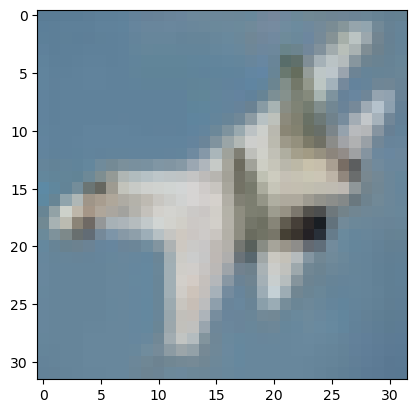

In [121]:
pic = testset.data[10,:,:,:]
plt.imshow(pic)
plt.show()

In [122]:
pic_tensor = torch.tensor(pic)
print(f'Tensor shape {pic_tensor.shape}')
print(f'Number of items in tensor {pic_tensor.shape.numel()}')

Tensor shape torch.Size([32, 32, 3])
Number of items in tensor 3072


In [123]:
full_train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,drop_last=True)
full_test_loader  = DataLoader(testset,batch_size=256)

In [124]:
trainsetSmall = torch.utils.data.Subset(trainset,range(2000))
testsetSmall  = torch.utils.data.Subset(testset,range(2000))

small_train_loader = DataLoader(trainsetSmall,batch_size=batch_size,shuffle=True,drop_last=True)
small_test_loader  = DataLoader(testsetSmall,batch_size=batch_size)

In [128]:
def CifarAE():
    class aenet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            self.encconv1 = nn.Conv2d(3,16,4,padding=1,stride=2)
            self.encconv2 = nn.Conv2d(16,32,4,padding=1,stride=2)
            self.encconv3 = nn.Conv2d(32,64,4,padding=1,stride=2)

            self.deconv1 = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)
            self.deconv2 = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
            self.deconv3 = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)

        def forward(self,x):
            x = F.leaky_relu(self.encconv1(x))
            x = F.leaky_relu(self.encconv2(x))
            x = F.leaky_relu(self.encconv3(x))

            x = F.leaky_relu(self.deconv1(x))
            x = F.leaky_relu(self.deconv2(x))
            x = F.leaky_relu(self.deconv3(x))

            return x

    net = aenet()
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5) 

    return net,lossfun,optimizer       

In [129]:
cifarAe, lossfun, optimizer = CifarAE()
cifarAe.to(device)

aenet(
  (encconv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (encconv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (encconv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [130]:
train_loss, test_loss, trained_model = trainAE(
    model=cifarAe,
    optimizer=optimizer,
    train_loader=full_train_loader,
    test_loader=full_test_loader,
    num_epochs=15,
    device=device
)

Epoch 1/15 - Train Loss: 0.0579 - Test Loss: 0.0343
Epoch 2/15 - Train Loss: 0.0284 - Test Loss: 0.0244
Epoch 3/15 - Train Loss: 0.0226 - Test Loss: 0.0217
Epoch 4/15 - Train Loss: 0.0204 - Test Loss: 0.0197
Epoch 5/15 - Train Loss: 0.0188 - Test Loss: 0.0184
Epoch 6/15 - Train Loss: 0.0176 - Test Loss: 0.0188
Epoch 7/15 - Train Loss: 0.0166 - Test Loss: 0.0163
Epoch 8/15 - Train Loss: 0.0157 - Test Loss: 0.0155
Epoch 9/15 - Train Loss: 0.0148 - Test Loss: 0.0147
Epoch 10/15 - Train Loss: 0.0140 - Test Loss: 0.0137
Epoch 11/15 - Train Loss: 0.0132 - Test Loss: 0.0131
Epoch 12/15 - Train Loss: 0.0127 - Test Loss: 0.0130
Epoch 13/15 - Train Loss: 0.0125 - Test Loss: 0.0126
Epoch 14/15 - Train Loss: 0.0121 - Test Loss: 0.0121
Epoch 15/15 - Train Loss: 0.0118 - Test Loss: 0.0120


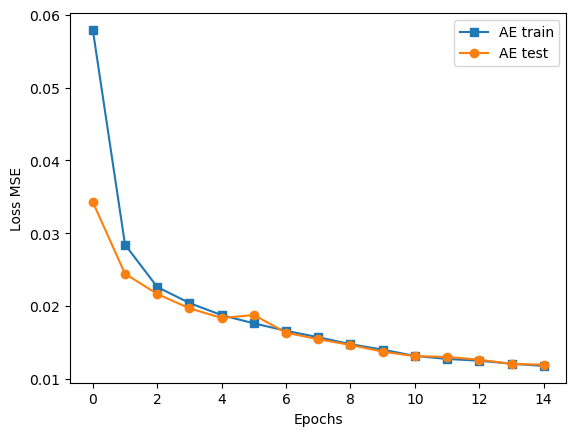

In [140]:
plt.plot(train_loss,'s-',label='AE train')
plt.plot(test_loss,'o-',label='AE test')
plt.xlabel('Epochs')
plt.ylabel('Loss MSE')
plt.legend()
plt.show()

In [145]:
def CifarClassification():
    class aenet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            self.encconv1 = nn.Conv2d(3,16,4,padding=1,stride=2)
            self.encconv2 = nn.Conv2d(16,32,4,padding=1,stride=2)
            self.encconv3 = nn.Conv2d(32,64,4,padding=1,stride=2)

            self.fc1 = nn.Linear(4*4*64,128)
            self.fc2 = nn.Linear(128,64)
            self.fc3 = nn.Linear(64,10)



        def forward(self,x):
            x = F.leaky_relu(self.encconv1(x))
            x = F.leaky_relu(self.encconv2(x))
            x = F.leaky_relu(self.encconv3(x))
            
            # reshape to linear
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1,int(nUnits))

            # linear layers

            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))


            return x

    net = aenet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5) 

    return net,lossfun,optimizer       

In [142]:
naiveNet,naivLossFun, naiveOptimizer = CifarClassification()
losses, train_accuracy, test_accuracy = trainTheM0del(
        isClassification=True,
        optimizer = naiveOptimizer,
        doBN=False,
        model=naiveNet,
        train_loader=small_train_loader,
        test_loader=small_test_loader,
        num_epochs=10, 
        loss_function= naivLossFun,
        device = device
        )

Epoch 1/10, Train Loss: 2.2462, Train Acc: 17.69, Test Acc: 25.00
Epoch 2/10, Train Loss: 2.0534, Train Acc: 25.60, Test Acc: 34.38
Epoch 3/10, Train Loss: 1.8970, Train Acc: 31.35, Test Acc: 46.88
Epoch 4/10, Train Loss: 1.7490, Train Acc: 36.09, Test Acc: 43.75
Epoch 5/10, Train Loss: 1.6365, Train Acc: 39.62, Test Acc: 34.38
Epoch 6/10, Train Loss: 1.5539, Train Acc: 44.30, Test Acc: 50.00
Epoch 7/10, Train Loss: 1.4682, Train Acc: 46.77, Test Acc: 46.88
Epoch 8/10, Train Loss: 1.3494, Train Acc: 51.66, Test Acc: 40.62
Epoch 9/10, Train Loss: 1.2428, Train Acc: 55.95, Test Acc: 43.75
Epoch 10/10, Train Loss: 1.1313, Train Acc: 59.17, Test Acc: 31.25


In [152]:
pretrainedNet,pretrainedLossFun, pretrainedOptimizer = CifarClassification()

for target,source in zip(pretrainedNet.named_parameters(),naiveNet.named_parameters()):
    if('enc' in target[0]):
        target[1].data = copy.deepcopy(source[1].data)
        target[1].requires_grad = False 

In [153]:
pretrainedNet.to(device)

aenet(
  (encconv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (encconv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (encconv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [154]:
# double check the weights 
pretrainedNet.cpu().encconv1.weight[10] - naiveNet.cpu().encconv1.weight[10] 

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<SubBackward0>)

In [156]:
losses, train_accuracy, test_accuracy = trainTheM0del(
        isClassification=True,
        optimizer = pretrainedOptimizer,
        doBN=False,
        model=pretrainedNet,
        train_loader=small_train_loader,
        test_loader=small_test_loader,
        num_epochs=30, 
        loss_function= pretrainedLossFun,
        device = device
        )

Epoch 1/30, Train Loss: 0.5248, Train Acc: 83.27, Test Acc: 37.50
Epoch 2/30, Train Loss: 0.4585, Train Acc: 86.69, Test Acc: 31.25
Epoch 3/30, Train Loss: 0.3822, Train Acc: 89.42, Test Acc: 37.50
Epoch 4/30, Train Loss: 0.3270, Train Acc: 90.32, Test Acc: 34.38
Epoch 5/30, Train Loss: 0.2684, Train Acc: 92.94, Test Acc: 34.38
Epoch 6/30, Train Loss: 0.2277, Train Acc: 94.76, Test Acc: 37.50
Epoch 7/30, Train Loss: 0.1964, Train Acc: 95.36, Test Acc: 37.50
Epoch 8/30, Train Loss: 0.1820, Train Acc: 95.06, Test Acc: 31.25
Epoch 9/30, Train Loss: 0.1482, Train Acc: 96.72, Test Acc: 37.50
Epoch 10/30, Train Loss: 0.1242, Train Acc: 97.43, Test Acc: 31.25
Epoch 11/30, Train Loss: 0.1087, Train Acc: 97.73, Test Acc: 37.50
Epoch 12/30, Train Loss: 0.1119, Train Acc: 97.63, Test Acc: 34.38
Epoch 13/30, Train Loss: 0.0803, Train Acc: 98.39, Test Acc: 31.25
Epoch 14/30, Train Loss: 0.0631, Train Acc: 98.74, Test Acc: 31.25
Epoch 15/30, Train Loss: 0.0548, Train Acc: 98.79, Test Acc: 34.38
Epoc